In [1]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split
caltech_dir = "D:/Games/Images/train"
categories = ["antelope", "cats", "chimpanzee", "cow", "dogs", "hippopotamus","horse","otter","raccoon","rat","rhinoceros","squirrel","weasel","wolf"]
nb_classes = len(categories)
print(caltech_dir)
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 이면 airplanes
#0 1 0 0 이면 buddha 이런식


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data3.npy", xy)

print("ok", len(y))



D:/Games/Images/train
antelope  파일 길이 :  0
cats  파일 길이 :  0
chimpanzee  파일 길이 :  0
cow  파일 길이 :  0
dogs  파일 길이 :  0
hippopotamus  파일 길이 :  0
horse  파일 길이 :  0
otter  파일 길이 :  0
raccoon  파일 길이 :  0
rat  파일 길이 :  0
rhinoceros  파일 길이 :  0
squirrel  파일 길이 :  0
weasel  파일 길이 :  0
wolf  파일 길이 :  0
ok 0


In [5]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras import optimizers
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data3.npy')
np.load = np_load_old
print(X_train.shape)
print(X_train.shape[0])

Using TensorFlow backend.


(0,)
0


In [6]:
categories = ["antelope", "cats", "chimpanzee", "cow", "dogs", "hippopotamus","horse","otter","raccoon","rat","rhinoceros","squirrel","weasel","wolf"]
nb_classes = len(categories)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [ ]:
with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    model.summary()
    

In [46]:

#데이터셋이 적어서 validation을 그냥 test 데이터로 했습니다. 
#데이터셋이 충분하시면 이렇게 하시지 마시고 validation_split=0.2 이렇게 하셔서 테스트 셋으로 나누시길 권장합니다.
history = model.fit(X_train, y_train, batch_size=34, epochs=100, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])



Train on 4623 samples, validate on 1541 samples
Epoch 1/100
4623/4623 [==============================] - 10s 2ms/step - loss: 13.5012 - acc: 0.1622 - val_loss: 13.5869 - val_acc: 0.1570

Epoch 00001: val_loss improved from inf to 13.58690, saving model to ./model/multi_img_classification.model
Epoch 2/100
4623/4623 [==============================] - 2s 468us/step - loss: 13.4753 - acc: 0.1640 - val_loss: 13.5869 - val_acc: 0.1570

Epoch 00002: val_loss did not improve from 13.58690
Epoch 3/100
4623/4623 [==============================] - 2s 470us/step - loss: 13.4753 - acc: 0.1640 - val_loss: 13.5869 - val_acc: 0.1570

Epoch 00003: val_loss did not improve from 13.58690
Epoch 4/100
4623/4623 [==============================] - 2s 481us/step - loss: 13.4753 - acc: 0.1640 - val_loss: 13.5869 - val_acc: 0.1570

Epoch 00004: val_loss did not improve from 13.58690
Epoch 5/100
4623/4623 [==============================] - 2s 471us/step - loss: 13.4753 - acc: 0.1640 - val_loss: 13.5869 - val_ac

In [47]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

1541/1541 [==============================] - 0s 173us/step
정확도 : 0.1570


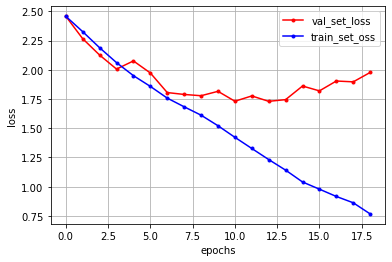

In [42]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [43]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "D:/Games/Images/val2"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#이 비교는 그냥 파일들이 있으면 해당 파일과 비교. 카테고리와 함께 비교해서 진행하는 것은 _4 파일.
for i in prediction:
    pre_ans = i.argmax()  # 예측 레이블
    print("i:",i)
    print("pre_ans: ",pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "antelope"
    elif pre_ans == 1: pre_ans_str = "cats"
    elif pre_ans == 2: pre_ans_str = "chimpanzee"
    elif pre_ans == 3: pre_ans_str = "cow"
    elif pre_ans == 4: pre_ans_str = "dogs"
    elif pre_ans == 5: pre_ans_str = "hippopotamus"
    elif pre_ans == 6: pre_ans_str = "horse"
    elif pre_ans == 7: pre_ans_str = "otter"
    elif pre_ans == 8: pre_ans_str = "raccooon"
    elif pre_ans == 9: pre_ans_str = "rat"
    elif pre_ans == 10: pre_ans_str = "rhinoceros"
    elif pre_ans == 11: pre_ans_str = "squirrel"
    elif pre_ans == 12: pre_ans_str = "weasel"
    else: pre_ans_str = "wolf"
    if i[0] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[4] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[5] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[6] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[7] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[8] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[9] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[10] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[11] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[12] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    cnt += 1
    # print(i.argmax()) #얘가 레이블 [1. 0. 0.] 이런식으로 되어 있는 것을 숫자로 바꿔주는 것.
    # 즉 얘랑, 나중에 카테고리 데이터 불러와서 카테고리랑 비교를 해서 같으면 맞는거고, 아니면 틀린거로 취급하면 된다.
    # 이걸 한 것은 _4.py에.


i: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000]
pre_ans:  3
해당 antelope1.jpg이미지는 cow로 추정됩니다.
i: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000]
pre_ans:  3
해당 cat.jpg이미지는 cow로 추정됩니다.
i: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000]
pre_ans:  2
해당 raccoon.jpg이미지는 chimpanzee로 추정됩니다.
i: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000]
pre_ans:  3
해당 raccoon2.jpg이미지는 cow로 추정됩니다.
i: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000]
pre_ans:  3
해당 rat.jpg이미지는 cow로 추정됩니다.
i: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000]
pre_ans:  1
해당 squirrel.jpg이미지는 cats으로 추정됩니다.
